<a href="https://colab.research.google.com/github/rafavidal1709/projeto_aplicado_iv/blob/main/Projeto_Aplicado_IV_Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

import ee
import os
import time
import math
import json
import datetime
import rasterio
import requests
import numpy as np
import pandas as pd
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
from io import BytesIO

ee.Authenticate()
ee.Initialize(project='ee-rafavidal1709')
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.9 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
class ImageId:
  def __init__(self, id):
    self.id = id
    last_bar = id.rfind('/')
    last_underline = id.rfind('_')
    self.collection = id[:last_bar]
    self.time = id[last_bar+1:last_underline]
    self.tile = id[last_underline+1:]

  def __print__(self):
    print(self.id)

  def __str__(self):
    return self.id

In [12]:
class Aquisitor:
  def __init__(self, region=None, collection=None, bands=None, drive_path=None, scale=10, uint8=False, sufix=None):
    self.collection = ee.ImageCollection(collection).filterBounds(region)
    self.region = region
    self.drive_path = drive_path
    self.bands = bands
    self.scale = scale
    self.uint8 = uint8
    if sufix is None:
      self.sufix = ""
    else:
      self.sufix = "_"+sufix

  def list(self, start_date, end_date=None, group=True):
    if end_date is None:
      start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
      end_date = (start_date+datetime.timedelta(days=1)).strftime('%Y-%m-%d')
      start_date = (start_date-datetime.timedelta(days=1)).strftime('%Y-%m-%d')

    col = self.collection.filterDate(start_date, end_date)
    image_list = col.toList(col.size())
    data = []

    for i in range(image_list.size().getInfo()):
      image = image_list.get(i).getInfo()
      id = ImageId(image['id'])
      coords = image['properties']['system:footprint']['coordinates']
      min_lon = min([point[0] for point in coords])
      min_lat = min([point[1] for point in coords])
      max_lon = max([point[0] for point in coords])
      max_lat = max([point[1] for point in coords])
      data.append({
        'id': str(id),
        'tile': id.tile,
        'clouds': image['properties'].get('CLOUDY_PIXEL_PERCENTAGE', None),
        'date': datetime.datetime.fromtimestamp(image['properties']['system:time_start']/1000),
        'min_lon': min_lon,
        'min_lat': min_lat,
        'max_lon': max_lon,
        'max_lat': max_lat
      })
    df = pd.DataFrame(data)

    if group:
      df = self.group_df(df)

    return df

  def group_df(self, df):
    df['time'] = df['date'].dt.strftime('%H:%M:%S.%f')
    df['time_milliseconds'] = df['date'].dt.hour * 3_600_000 + \
                              df['date'].dt.minute * 60_000 + \
                              df['date'].dt.second * 1_000 + \
                              df['date'].dt.microsecond // 1_000

    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    df = df.groupby('date').agg({
        'min_lat': 'min',
        'min_lon': 'min',
        'max_lat': 'max',
        'max_lon': 'max',
        'time_milliseconds': 'mean',
        'clouds': 'mean',
        'tile': lambda x: list(x),
        'id': lambda x: list(x)
    }).reset_index()

    df['time'] = df['time_milliseconds'].apply(lambda ms:
        f"{int(ms // 3_600_000):02d}:{int((ms % 3_600_000) // 60_000):02d}:{int((ms % 60_000) // 1_000):02d}.{int(ms % 1_000):03d}")

    df = df.drop(columns=['time_milliseconds'])
    df = df[['date', 'time', 'clouds', 'tile', 'min_lat', 'min_lon', 'max_lat', 'max_lon', 'id']]

    return df

  def download(self, date):
    df = self.list(date)
    if df.empty:
        print("Nenhuma imagem encontrada para a data fornecida.")
        return

    image_id = df.iloc[0]['date'].replace('-', '_')
    id_list = df.iloc[0].id

    if len(id_list) > 1:
        images = [ee.Image(image_id) for image_id in id_list]
        image = ee.ImageCollection(images).mosaic()
        print(f"Exportando mosaico de: {', '.join(id_list)}")
    else:
        image = ee.Image(id_list[0])
        print(f"Exportando imagem {id_list[0]}")

    if self.bands:
        image = image.select(self.bands)

    if self.uint8:
        image = image.toUint8()
    else:
        image = image.toUint16()

    image_geometry = image.geometry().intersection(self.region)

    export_task = ee.batch.Export.image.toDrive(
        image=image,
        description=image_id+self.sufix,
        fileNamePrefix=image_id+self.sufix,
        folder=self.drive_path,
        scale=self.scale,
        region=image_geometry.getInfo()['coordinates'],
        maxPixels=1e13,
        crs='EPSG:4326'
    )

    export_task.start()
    print(f"Exportação de {image_id} iniciada.")

    return image_id

  def activity(self, max_tasks=10):
    tasks = ee.batch.Task.list()

    if not tasks:
        print("Nenhuma tarefa encontrada.")
    else:
        for task in tasks:
            if max_tasks <= 0:
                break
            max_tasks -= 1
            print(f"Tarefa: {task.config['description']}")
            print(f"Status: {task.status()['state']}")
            if 'error_message' in task.status():
                print(f"Erro: {task.status()['error_message']}")
            print("-" * 40)


In [11]:
class Dataset:
  def __init__(self, local_path=None, region=None):
    self.local_path = local_path
    self.region = region

  def list(self, format=None):
    files = os.listdir(self.local_path)
    if format is None:
      return files
    else:
      return [f for f in files if f.endswith(f".{format}")]

  def open_tif(self, id, header_info=False):
    id = id.replace("-","_")

    with rasterio.open(os.path.join(self.local_path, f"{id}.tif")) as dataset:
      width = dataset.width
      height = dataset.height
      channels = dataset.count
      X = dataset.read()
      channel_sizes = [np.dtype(dataset.dtypes[i - 1]).itemsize for i in range(1, channels + 1)]

    if header_info:
      print(f"Width: {width}, Height: {height}, Channels: {channels}")
      print(f"Channel Sizes (bytes per pixel): {channel_sizes}")
      print(f"X shape: {X.shape}")

    return X

  def analysis(self, id, header_info=True):
    if isinstance(id, str):
      X = self.open_tif(id, header_info)
    else:
      X = id
      id = "X"

    stats = []
    for i in range(X.shape[0]):
        channel = X[i, :, :].flatten()

        max_val = np.max(channel)
        min_val = np.min(channel)
        median_val = np.median(channel)
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        q2 = np.percentile(channel, 25)
        q3 = np.percentile(channel, 75)

        stats.append({
            'Canal': i + 1,
            'Máximo': max_val,
            'Mínimo': min_val,
            'Mediana': median_val,
            'Média': mean_val,
            'Desvio Padrão': std_val,
            '2º Quartil': q2,
            '3º Quartil': q3
        })

    plt.figure(figsize=(12, 6))
    plt.boxplot([X[i, :, :].flatten() for i in range(X.shape[0])], vert=True, patch_artist=True)
    plt.xlabel('Canal')
    plt.ylabel('Valor')
    plt.title(id)
    plt.xticks(ticks=np.arange(1, X.shape[0] + 1), labels=np.arange(0, X.shape[0]))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return pd.DataFrame(stats)

  def getRegion(self, lat, lon, wid, hei, width, height):
    coords = self.region.coordinates().getInfo()[0]
    minLon = min(coord[0] for coord in coords)
    maxLon = max(coord[0] for coord in coords)
    minLat = min(coord[1] for coord in coords)
    maxLat = max(coord[1] for coord in coords)

    x = (lon - minLon) / (maxLon - minLon) * (width - 1)
    y = (1 - (lat - minLat) / (maxLat - minLat)) * (height - 1)  # Inverta o cálculo de Y
    minX = math.ceil(x - wid / 2)
    maxX = minX + wid
    minY = math.ceil(y - hei / 2)
    maxY = minY + hei

    if minX < 0:
        minX = 0
    if maxX > width:
        maxX = width
    if minY < 0:
        minY = 0
    if maxY > height:
        maxY = height

    return minX, maxX, minY, maxY

  def show(self, id, lat, lon, wid, hei, Ri, Gi, Bi, scaler="standard"):
    if isinstance(id, str):
        X = self.open_tif(id)
    else:
        X = id

    minX, maxX, minY, maxY = self.getRegion(lat, lon, wid, hei, X.shape[2], X.shape[1])

    R = X[Ri, minY:maxY, minX:maxX]
    G = X[Gi, minY:maxY, minX:maxX]
    B = X[Bi, minY:maxY, minX:maxX]

    def standard_scale(channel):
        """Aplica StandardScaler e reescala dentro do intervalo de -3x a +3x o desvio padrão."""
        scaler = StandardScaler()
        channel_scaled = scaler.fit_transform(channel.reshape(-1, 1)).reshape(channel.shape)

        mean = np.mean(channel_scaled)
        std = np.std(channel_scaled)

        min_val = mean - std
        max_val = mean + std

        if(max_val==min_val):
          max_val = min_val + 1

        # Clipa e normaliza no intervalo [0, 255]
        channel_rescaled = np.clip((channel_scaled - min_val) / (max_val - min_val) * 255.0, 0, 255)
        return channel_rescaled

    if scaler == "standard":
        R_final = standard_scale(R)
        G_final = standard_scale(G)
        B_final = standard_scale(B)
    elif scaler == "minmax":
        minmax_scaler = MinMaxScaler(feature_range=(0, 255))
        R_final = minmax_scaler.fit_transform(R.reshape(-1, 1)).reshape(R.shape)
        G_final = minmax_scaler.fit_transform(G.reshape(-1, 1)).reshape(G.shape)
        B_final = minmax_scaler.fit_transform(B.reshape(-1, 1)).reshape(B.shape)

    rgb_image = np.stack([R_final, G_final, B_final], axis=-1)

    plt.imshow(rgb_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    return rgb_image


In [5]:
class API:
  def __init__(self):
    self.url = "https://carcara.asav.com.br/api/"
    self.max_size = 5 * 1024 * 1024

  def use(self, data_dict, files=None):
      headers = {
          "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
          "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
          "Referer": "https://carcara.asav.com.br/",
          "Origin": "https://carcara.asav.com.br",
          "Connection": "keep-alive",
          "Upgrade-Insecure-Requests": "1",
          "Accept-Language": "en-US,en;q=0.5",
      }

      session = requests.Session()

      try:
          if files:
              response = session.post(self.url, data=data_dict, files=files, headers=headers, allow_redirects=True)
          else:
              headers["Content-Type"] = "application/x-www-form-urlencoded"
              data = requests.utils.requote_uri("&".join(f"{key}={value}" for key, value in data_dict.items()))
              response = session.post(self.url, data=data, headers=headers, allow_redirects=True)

          if response.status_code == 200:
              return response.json()
          else:
              return {"success": False, "error": f"Erro HTTP {response.status_code}: {response.text}"}

      except requests.exceptions.RequestException as e:
          return {"success": False, "error": "Exception: " + str(e)}


  def listFiles(self):
    res = self.use({"action": "listFiles"})
    if res["success"]:
      return res["files"]
    return False

  def renameFile(self, old_name, new_name):
    data = {
        "action": "renameFile",
        "old_name": old_name,
        "new_name": new_name
    }
    return self.use(data)

  def uploadFile(self, file, mode="write"):
    if isinstance(file, str):
        file_path = file
        file_size = os.path.getsize(file_path)
        file_name = os.path.basename(file_path)
    else:
        file_content = file.read()
        file_size = len(file_content)
        file_name = getattr(file, 'name', f"uploaded_{int(time.time())}")

    max_size = self.max_size

    if file_size <= max_size:
        print(f"Arquivo '{file_name}' pequeno ({file_size} bytes). Fazendo upload direto.")
        if isinstance(file, str):
            with open(file_path, "rb") as f:
                return self.use({"action": "uploadFile", "mode": mode}, files={"file": f})
        else:
            return self.use({"action": "uploadFile", "mode": mode}, files={"file": (file_name, file_content)})

    print(f"Arquivo '{file_name}' grande ({file_size} bytes). Fazendo upload em partes de {max_size} bytes.")
    timestamp = int(time.time())
    temp_file_name = f"{file_name}.temp.{timestamp}"

    total_parts = (file_size + max_size - 1) // max_size

    with tqdm(total=file_size, unit='B', unit_scale=True, desc=f"Enviando {file_name}") as pbar:
        if isinstance(file, str):
            with open(file_path, "rb") as f:
                self._upload_chunks(f, temp_file_name, max_size, pbar)
        else:
            from io import BytesIO
            f = BytesIO(file_content)
            self._upload_chunks(f, temp_file_name, max_size, pbar)

    rename_response = self.renameFile(temp_file_name, file_name)

    if rename_response.get("success"):
        print("Upload realizado com sucesso!")
        return True
    else:
        print(f"Erro ao renomear: {rename_response.get('error')}")
        return False

  def _upload_chunks(self, file_stream, temp_file_name, max_size, pbar):
      part_number = 0
      while True:
          chunk = file_stream.read(max_size)
          if not chunk:
              break

          part_number += 1
          mode = "overwrite" if part_number == 1 else "append"
          data = {"action": "uploadFile", "mode": mode}
          files = {"file": (temp_file_name, chunk)}
          response = self.use(data, files=files)

          if not response.get("success"):
              print(f"Erro ao enviar parte {part_number}: {response.get('error')}")
              raise Exception(f"Falha ao enviar parte {part_number}: {response.get('error')}")

          pbar.update(len(chunk))


In [38]:
class Carcara:
  def __init__(self, region=None, collection=None, bands=None, drive_path=None, local_path=None):
    self.region = region
    self.aquisitor = Aquisitor(collection=collection, region=region, drive_path=drive_path, bands=bands)
    self.SCLaquisitor = Aquisitor(collection=collection, region=region, drive_path=drive_path, bands=["SCL"], uint8=True, sufix="scl")
    self.dataset = Dataset(local_path=local_path, region=region)
    self.api = API()

region = ee.Geometry.Rectangle([-45.09643, -21.88779, -44.82858, -21.60614])
carcara = Carcara(
    region = region,
    collection = "COPERNICUS/S2_SR_HARMONIZED",
    bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"],
    drive_path = "copernicus_s2_sr_harmonized",
    local_path = "/content/drive/MyDrive/copernicus_s2_sr_harmonized"
  )

In [7]:
# Obtendo as listas de arquivos
tif_files = carcara.dataset.list('tif')  # Lista de arquivos .tif
api_files = carcara.api.listFiles()  # Lista de arquivos na API

# Filtrando os arquivos .tif que não estão na lista da API
filtered_files = [file for file in tif_files if file not in api_files]

# A lista filtered_files agora contém os arquivos .tif que não estão em api_files
print(f"(LOCAL : {len(tif_files)} ) - (SERVER: {len(api_files)} ) = (LACKING: {len(filtered_files)})")


(LOCAL : 455 ) - (SERVER: 455 ) = (LACKING: 0)


In [ ]:
count = 0
for file in filtered_files:
  count+=1
  print(f">> {count} de {len(filtered_files)} - {file}")
#  carcara.api.uploadFile("/content/drive/MyDrive/copernicus_s2_sr_harmonized/"+file) # Tome cuidado ao fazer upload pela API para não bagunçar o repositório

>> 1 de 1 - 2024_12_31.tif
Arquivo '2024_12_31.tif' grande (216320729 bytes). Fazendo upload em partes de 5242880 bytes.


Enviando 2024_12_31.tif: 100%|██████████| 216M/216M [00:54<00:00, 3.96MB/s]

Upload realizado com sucesso!


In [14]:
samples = Carcara(
    region = region,
    collection = "COPERNICUS/S2_SR_HARMONIZED",
    bands = None,
    drive_path = "copernicus_s2_sr_harmonized_samples",
    local_path = "/content/drive/MyDrive/copernicus_s2_sr_harmonized_samples"
  )

In [26]:
samples.SCLaquisitor.download('2025-02-14')

Exportando mosaico de: COPERNICUS/S2_SR_HARMONIZED/20250214T131249_20250214T131404_T23KMR, COPERNICUS/S2_SR_HARMONIZED/20250214T131249_20250214T131404_T23KMS, COPERNICUS/S2_SR_HARMONIZED/20250214T131249_20250214T131404_T23KNR, COPERNICUS/S2_SR_HARMONIZED/20250214T131249_20250214T131404_T23KNS
Exportação de 2025_02_14 iniciada.


'2025_02_14'

In [18]:
samples.SCLaquisitor.activity(1)

Tarefa: 2025_02_09_scl
Status: RUNNING
----------------------------------------


In [34]:
# A solicitação abaixo pode levar horas para ser executada, por isso recomenda-se abrir o arquivo pronto

# df = carcara.aquisitor.list('2012-01-01', '2025-04-30')
# df.head(20)
# df.drop(index=[0], inplace=True) # Removemos o primeiro item que está descompasado no tempo e não contém todos os quadrantes necessários.
# df.to_json('/content/drive/MyDrive/copernicus_s2_sr_harmonized/index.json', orient='records')

df = pd.read_json('/content/drive/MyDrive/copernicus_s2_sr_harmonized/index.json', orient='records')
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df.head(5)

date          time     clouds                              tile  \
0  2018-12-13  13:18:06.250   4.240136  [T23KMR, T23KMS, T23KNR, T23KNS]   
1  2018-12-18  13:18:09.845  16.516185  [T23KMR, T23KMS, T23KNR, T23KNS]   
2  2018-12-23  13:18:07.285  44.202089  [T23KMR, T23KMS, T23KNR, T23KNS]   
3  2018-12-28  13:18:11.750  54.764761  [T23KMR, T23KMS, T23KNR, T23KNS]   
4  2019-01-02  13:18:08.750  33.598728  [T23KMR, T23KMS, T23KNR, T23KNS]   

     min_lat    min_lon    max_lat    max_lon  \
0 -22.695298 -45.974046 -20.796368 -43.940256   
1 -22.695298 -45.974046 -20.796367 -43.940752   
2 -22.695298 -45.974046 -20.796368 -43.940667   
3 -22.695298 -45.974046 -20.796368 -43.940696   
4 -22.695298 -45.974046 -20.796368 -43.940480   

                                                  id  
0  [COPERNICUS/S2_SR_HARMONIZED/20181213T131231_2...  
1  [COPERNICUS/S2_SR_HARMONIZED/20181218T131239_2...  
2  [COPERNICUS/S2_SR_HARMONIZED/20181223T131241_2...  
3  [COPERNICUS/S2_SR_HARMONIZED/20181228T131239_2...  
4  [COPERNICUS/S2_SR_HARMONIZED/20190102T131241_2...

In [35]:
df.shape

(455, 9)

In [36]:
start = 4
step = 4

In [37]:
df[start:start+step]

date          time     clouds                              tile  \
0  2018-12-13  13:18:06.250   4.240136  [T23KMR, T23KMS, T23KNR, T23KNS]   
1  2018-12-18  13:18:09.845  16.516185  [T23KMR, T23KMS, T23KNR, T23KNS]   
2  2018-12-23  13:18:07.285  44.202089  [T23KMR, T23KMS, T23KNR, T23KNS]   
3  2018-12-28  13:18:11.750  54.764761  [T23KMR, T23KMS, T23KNR, T23KNS]   

     min_lat    min_lon    max_lat    max_lon  \
0 -22.695298 -45.974046 -20.796368 -43.940256   
1 -22.695298 -45.974046 -20.796367 -43.940752   
2 -22.695298 -45.974046 -20.796368 -43.940667   
3 -22.695298 -45.974046 -20.796368 -43.940696   

                                                  id  
0  [COPERNICUS/S2_SR_HARMONIZED/20181213T131231_2...  
1  [COPERNICUS/S2_SR_HARMONIZED/20181218T131239_2...  
2  [COPERNICUS/S2_SR_HARMONIZED/20181223T131241_2...  
3  [COPERNICUS/S2_SR_HARMONIZED/20181228T131239_2...

In [39]:
id = [df.iloc[i].date for i in range(start, start+step)]
print(f"Iniciando no índice: {start}")
print(f"Finalizando no índice: {start+step}")
print("-"*20)
for i in id:
  print(i)
  carcara.SCLaquisitor.download(i)
  print("-"*20)
start+=step

Iniciando no índice: 0
Finalizando no índice: 4
--------------------
2018-12-13
Exportando mosaico de: COPERNICUS/S2_SR_HARMONIZED/20181213T131231_20181213T131234_T23KMR, COPERNICUS/S2_SR_HARMONIZED/20181213T131231_20181213T131234_T23KMS, COPERNICUS/S2_SR_HARMONIZED/20181213T131231_20181213T131234_T23KNR, COPERNICUS/S2_SR_HARMONIZED/20181213T131231_20181213T131234_T23KNS
Exportação de 2018_12_13 iniciada.
--------------------
2018-12-18
Exportando mosaico de: COPERNICUS/S2_SR_HARMONIZED/20181218T131239_20181218T131237_T23KMR, COPERNICUS/S2_SR_HARMONIZED/20181218T131239_20181218T131237_T23KMS, COPERNICUS/S2_SR_HARMONIZED/20181218T131239_20181218T131237_T23KNR, COPERNICUS/S2_SR_HARMONIZED/20181218T131239_20181218T131237_T23KNS
Exportação de 2018_12_18 iniciada.
--------------------
2018-12-23
Exportando mosaico de: COPERNICUS/S2_SR_HARMONIZED/20181223T131241_20181223T131235_T23KMR, COPERNICUS/S2_SR_HARMONIZED/20181223T131241_20181223T131235_T23KMS, COPERNICUS/S2_SR_HARMONIZED/20181223T13

In [ ]:
downloaded = carcara.dataset.list('tif')
print(f"Baixados: {len(downloaded)} de {df.shape[0]} ({len(downloaded)*100/df.shape[0]:.2f}%)")
#downloaded

Baixados: 455 de 455 (100.00%)


In [41]:
carcara.aquisitor.activity(4)

Tarefa: 2018_12_28_scl
Status: COMPLETED
----------------------------------------
Tarefa: 2018_12_23_scl
Status: COMPLETED
----------------------------------------
Tarefa: 2018_12_18_scl
Status: COMPLETED
----------------------------------------
Tarefa: 2018_12_13_scl
Status: COMPLETED
----------------------------------------


In [44]:
carcara.dataset.list("tif")

['2025_01_05.tif',
 '2025_01_10.tif',
 '2025_01_15.tif',
 '2025_01_20.tif',
 '2025_01_25.tif',
 '2025_01_30.tif',
 '2025_02_04.tif',
 '2025_02_09.tif',
 '2025_02_14.tif',
 '2025_02_19.tif',
 '2025_02_24.tif',
 '2025_03_01.tif',
 '2018_12_13.tif',
 '2018_12_18.tif',
 '2018_12_23.tif',
 '2018_12_28.tif',
 '2019_01_02.tif',
 '2019_01_07.tif',
 '2019_01_12.tif',
 '2019_01_17.tif',
 '2019_01_22.tif',
 '2019_01_27.tif',
 '2019_02_01.tif',
 '2019_02_06.tif',
 '2019_02_11.tif',
 '2019_02_16.tif',
 '2019_02_21.tif',
 '2019_02_26.tif',
 '2019_03_03.tif',
 '2019_03_08.tif',
 '2019_03_13.tif',
 '2019_03_18.tif',
 '2019_03_23.tif',
 '2019_03_28.tif',
 '2019_04_02.tif',
 '2019_04_07.tif',
 '2019_04_12.tif',
 '2019_04_17.tif',
 '2019_04_22.tif',
 '2019_04_27.tif',
 '2019_05_02.tif',
 '2019_05_07.tif',
 '2019_05_12.tif',
 '2019_05_17.tif',
 '2019_05_22.tif',
 '2019_05_27.tif',
 '2019_06_01.tif',
 '2019_06_06.tif',
 '2019_06_11.tif',
 '2019_06_16.tif',
 '2019_06_21.tif',
 '2019_06_26.tif',
 '2019_07_01

Data: 2019-02-06


--------------------
Data: 2019-02-11


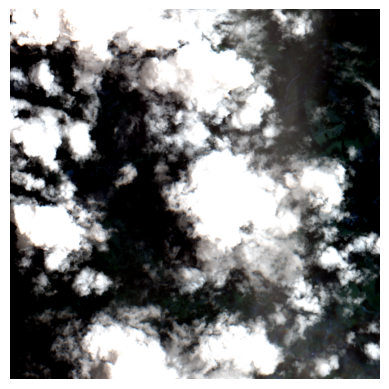

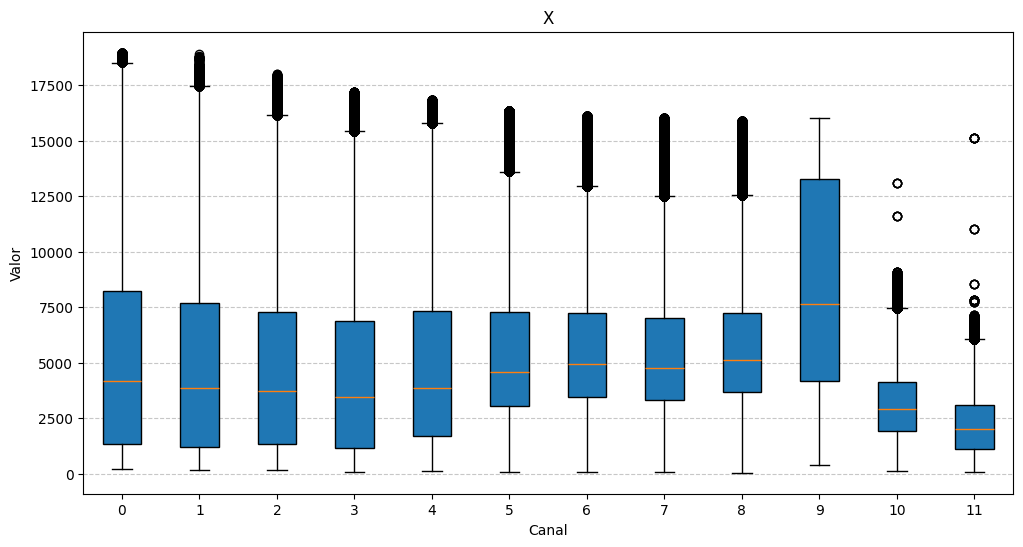

--------------------
Data: 2019-02-16


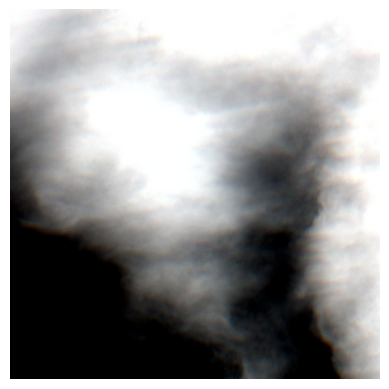

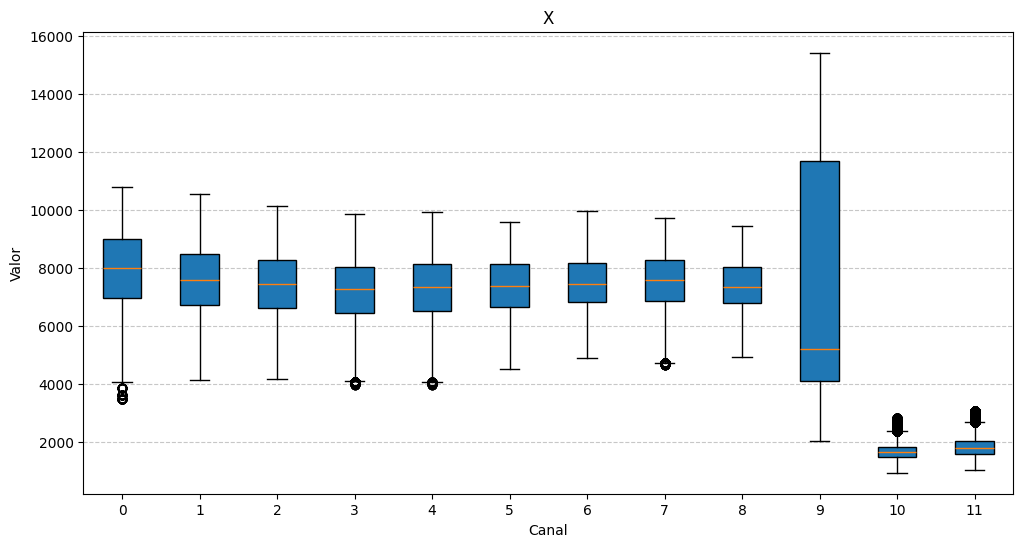

--------------------
Data: 2019-02-21


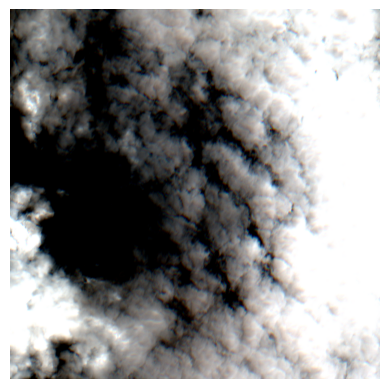

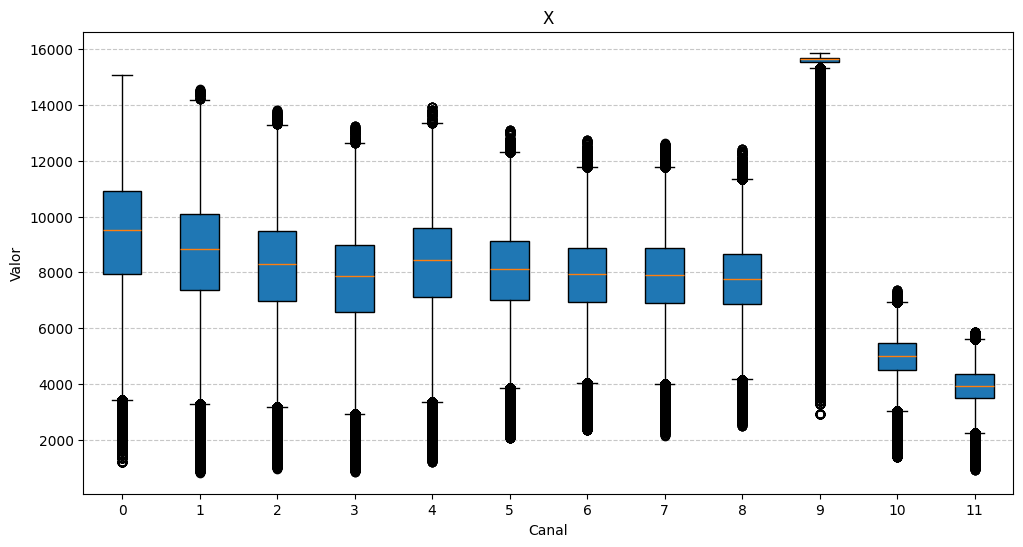

--------------------
Data: 2019-02-26


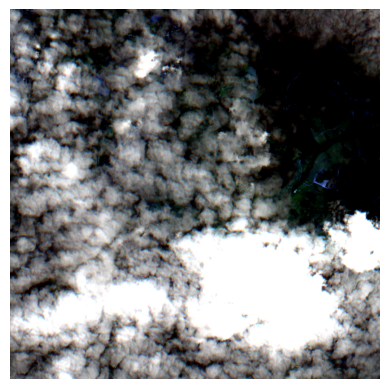

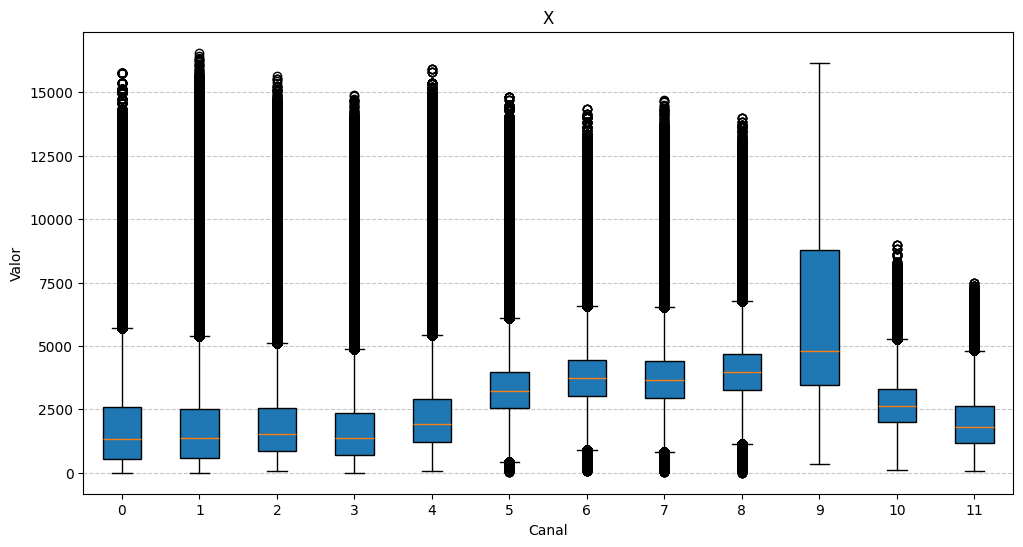

--------------------
Data: 2019-03-03


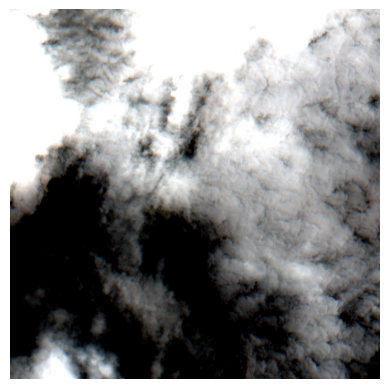

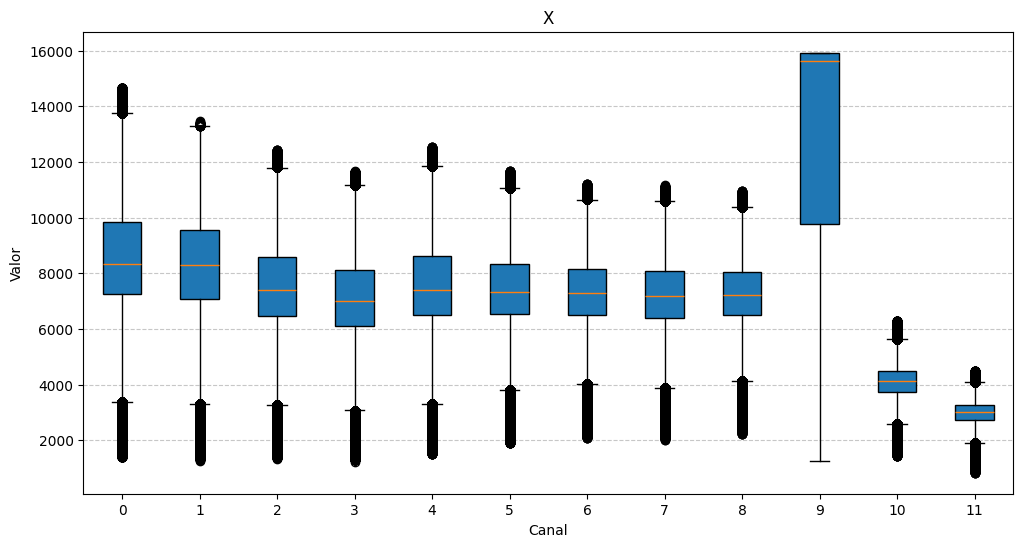

--------------------
Data: 2019-03-08


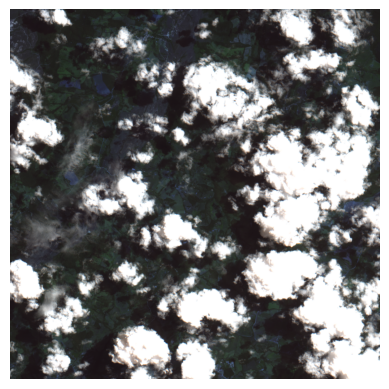

--------------------
Data: 2019-03-13


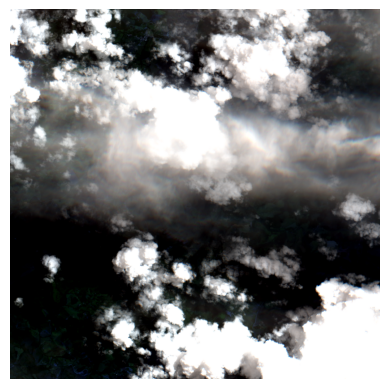

--------------------
Data: 2019-03-18


--------------------
Data: 2019-03-23


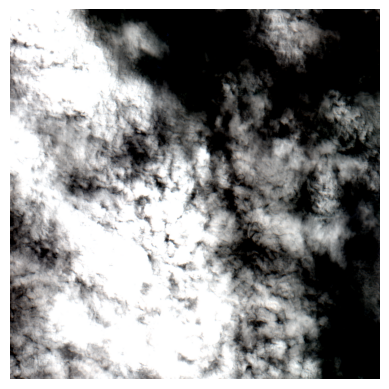

--------------------
Data: 2019-03-28


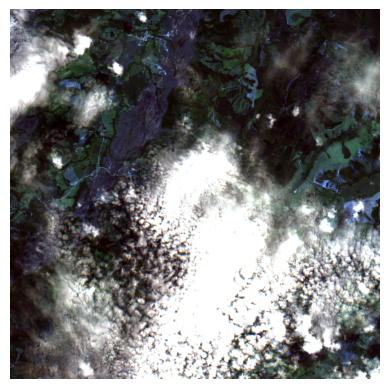

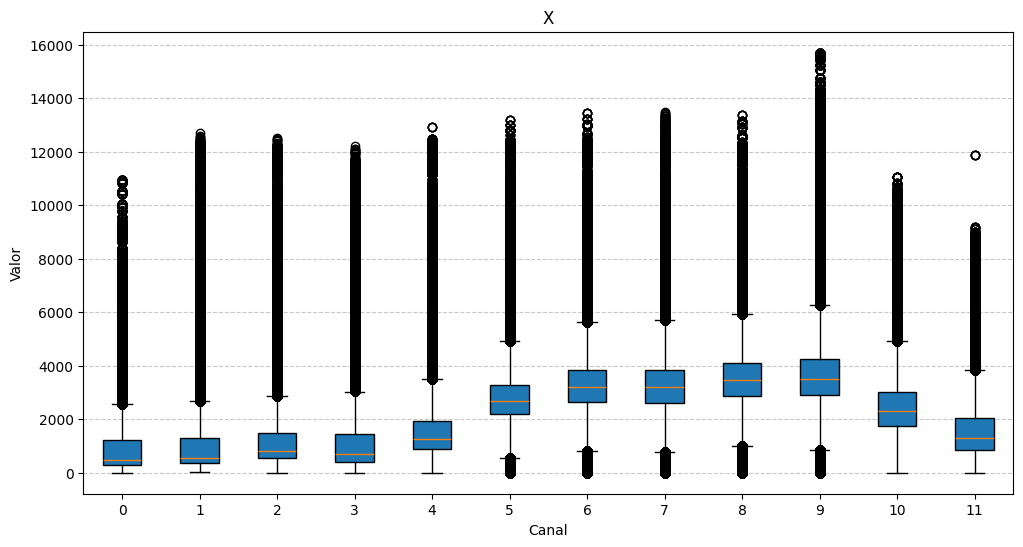

--------------------
Data: 2019-04-02


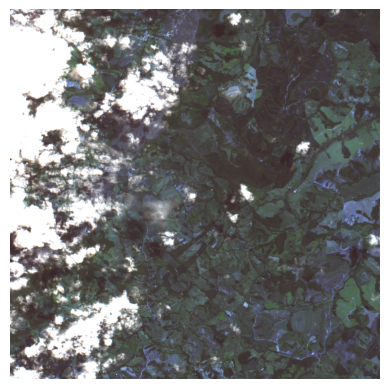

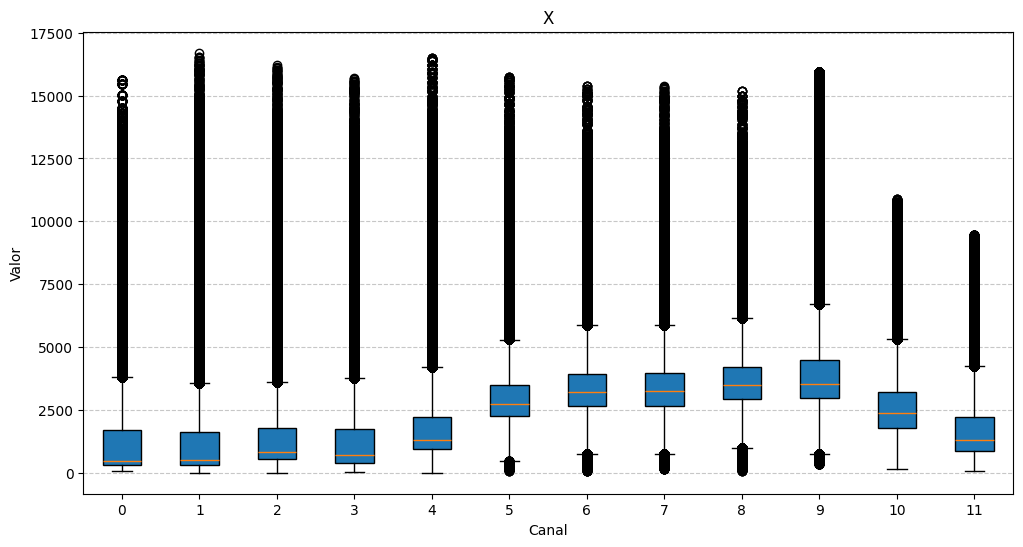

--------------------


In [ ]:
for i in id:
  X = carcara.dataset.open_tif(i)
  print(f"Data: {i}")
  carcara.dataset.show(X, -21.69401, -44.88277, 1200, 1200, 1, 2, 3)
  carcara.dataset.analysis(X)
  print("-"*20)

2025_01_05.tif


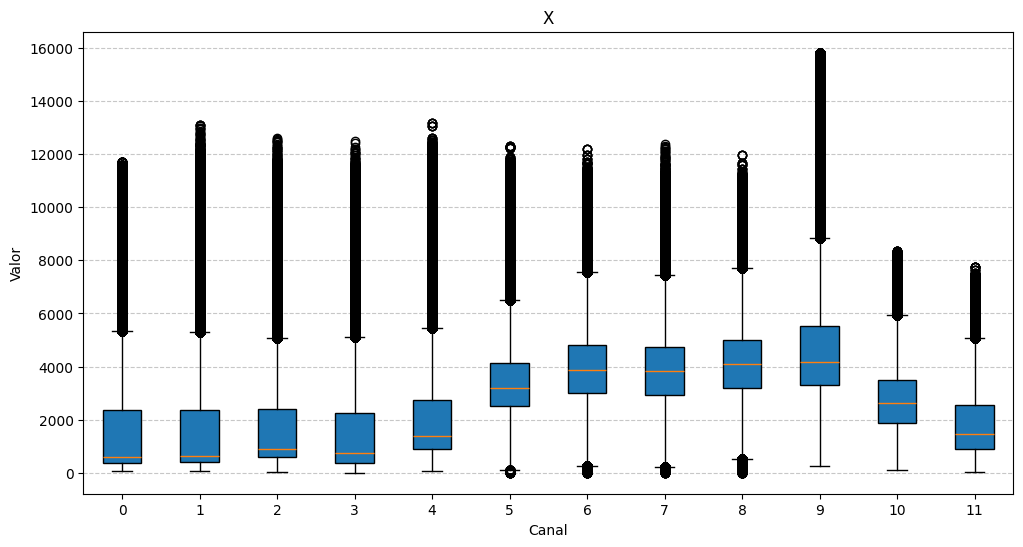

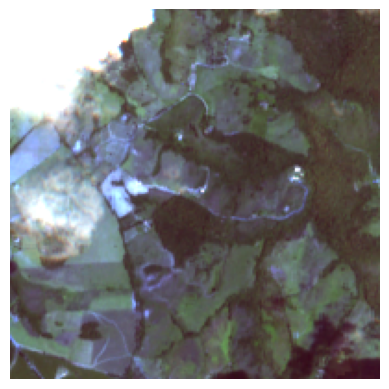

2025_01_10.tif


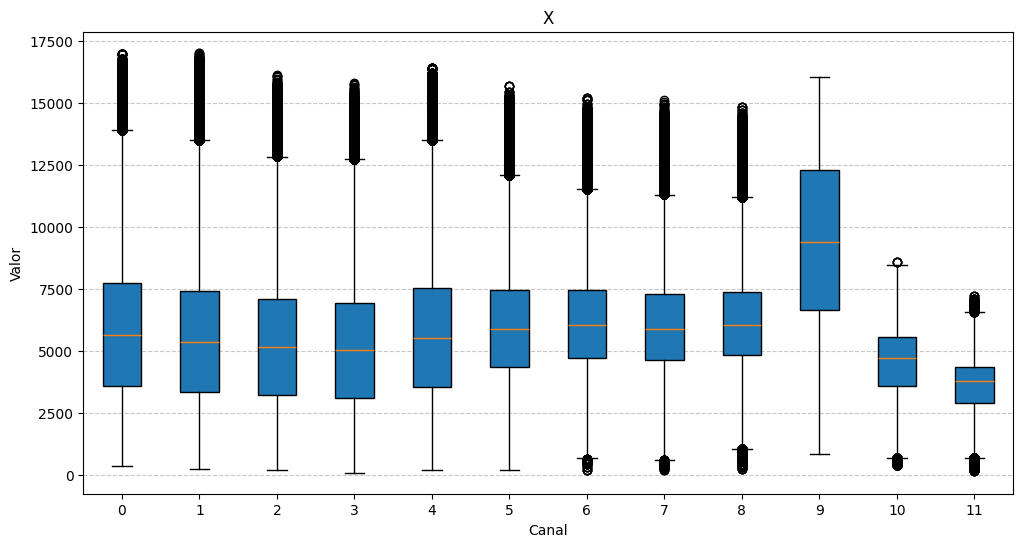

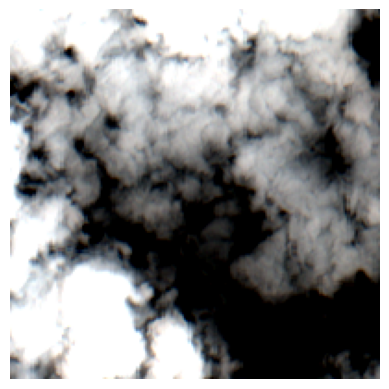

2025_01_15.tif


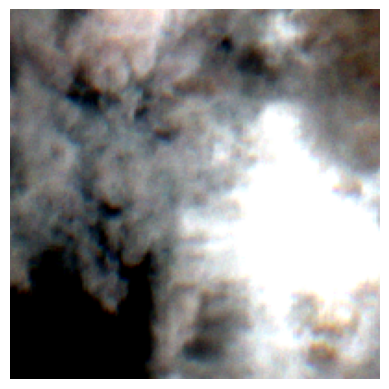

2025_01_20.tif


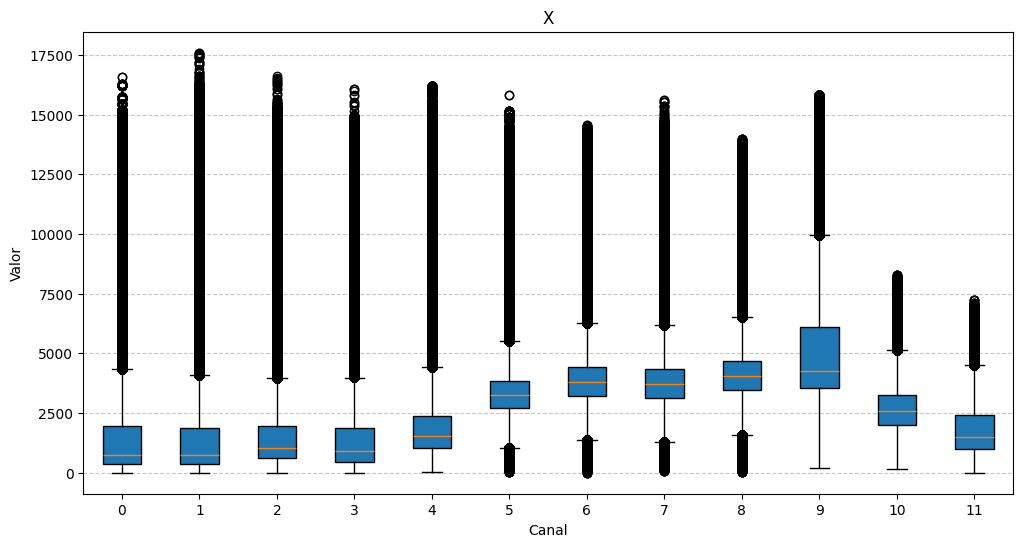

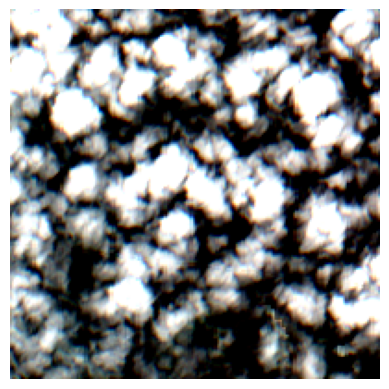

2025_01_25.tif


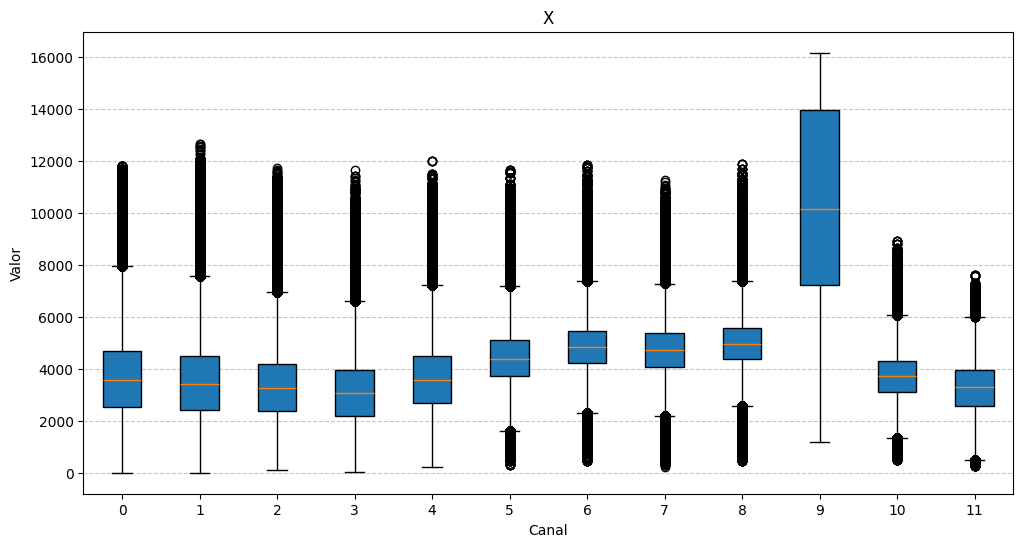

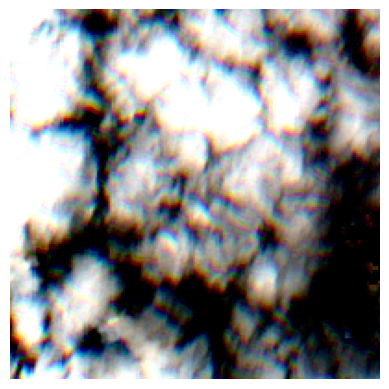

2025_01_30.tif


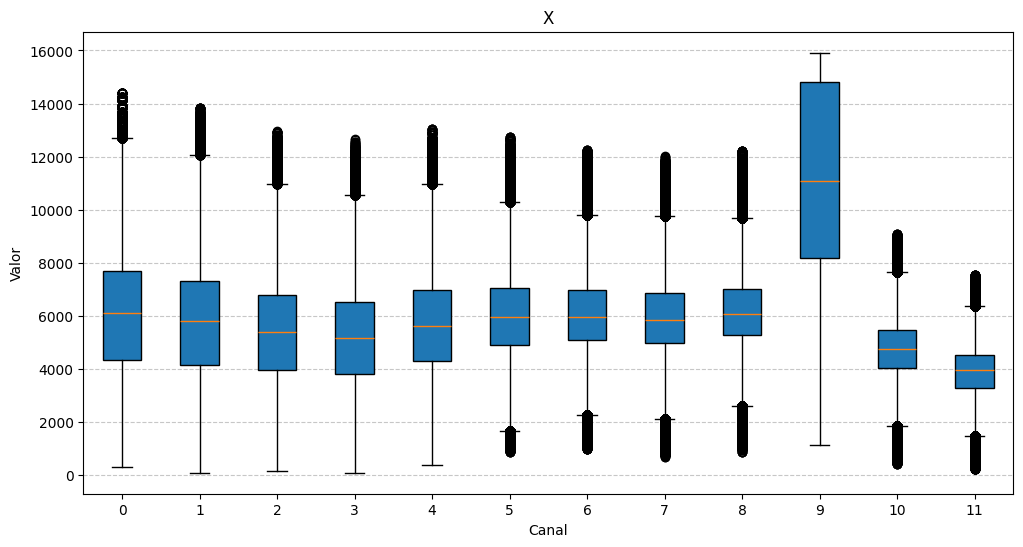

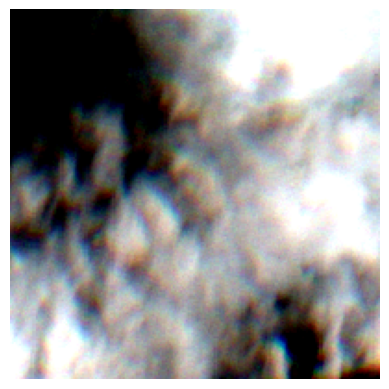

2025_02_04.tif


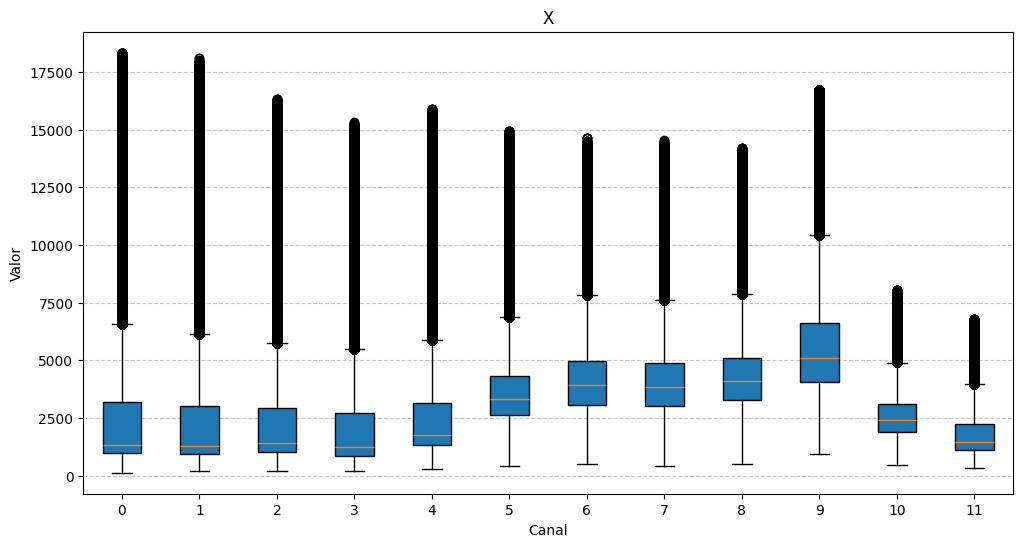

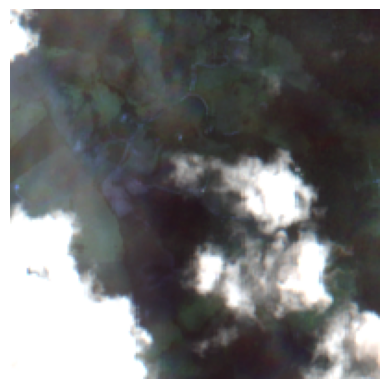

2025_02_09.tif


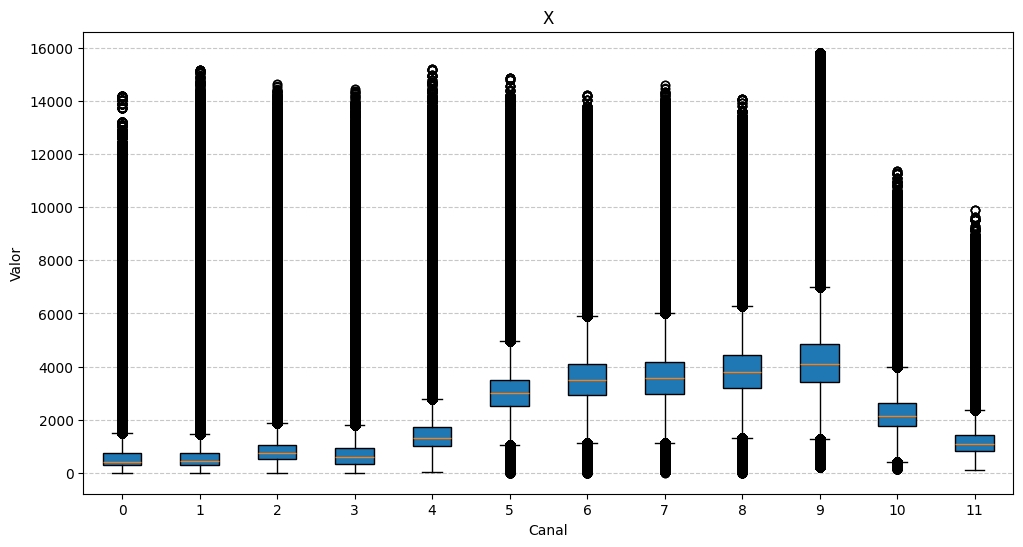

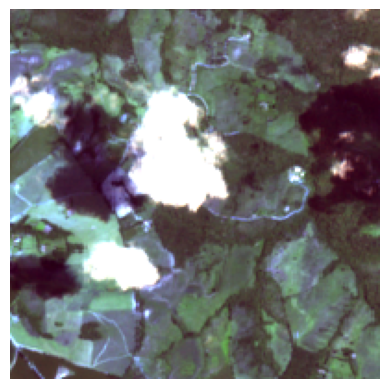

2025_02_14.tif


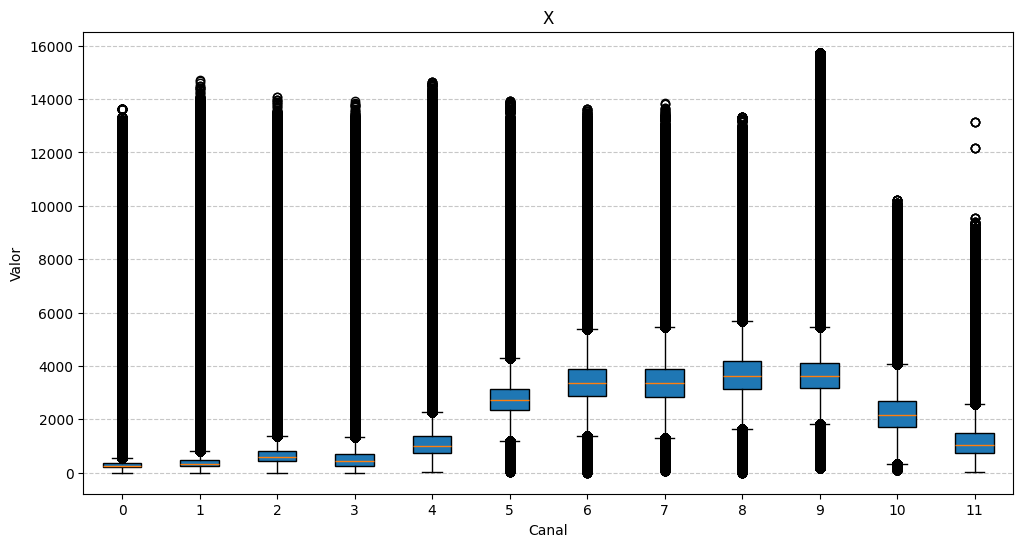

2025_02_19.tif


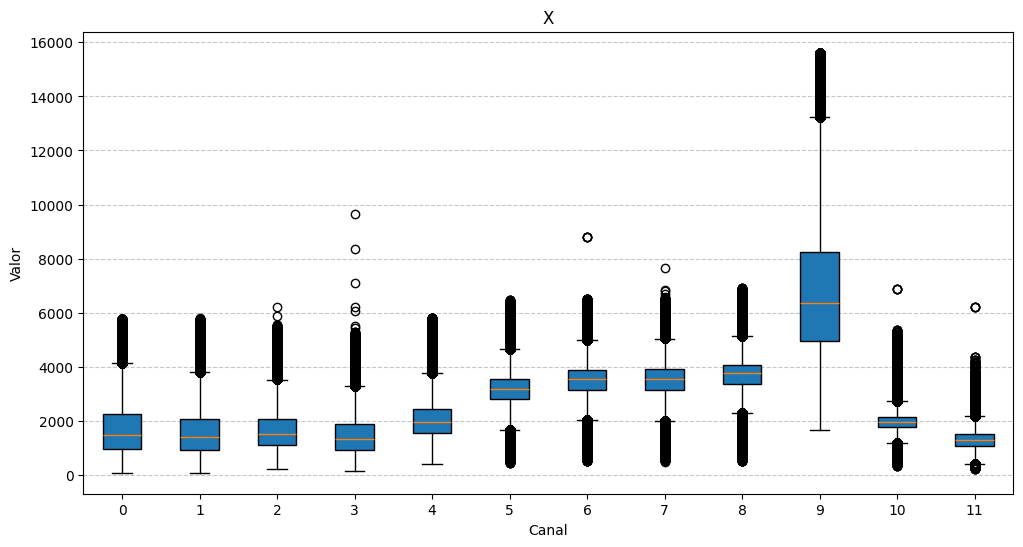

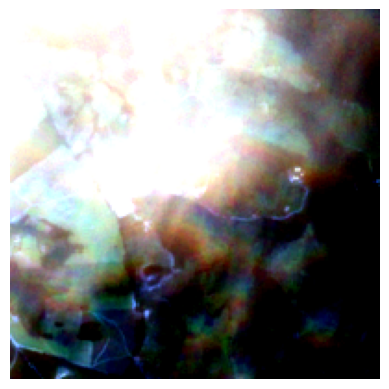

2025_02_24.tif


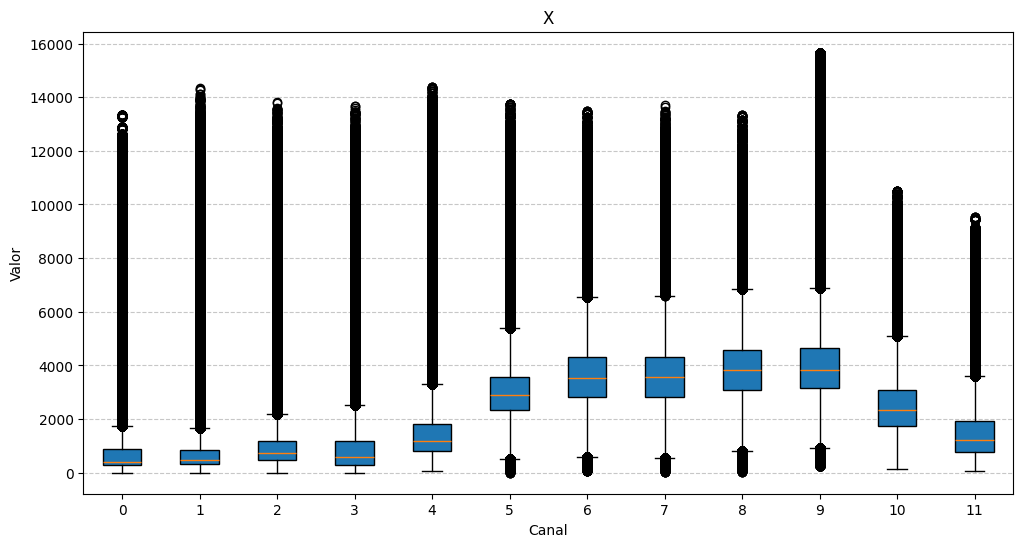

2025_03_01.tif


In [ ]:
for f in carcara.dataset.list('tif'):
  print(f)
  X = carcara.dataset.open_tif(f[0:10])
  carcara.dataset.analysis(X, header_info=False)
  carcara.dataset.show(X, -21.69401, -44.88277, 200, 200, 1, 2, 3)

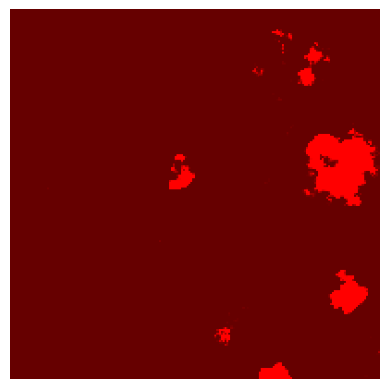

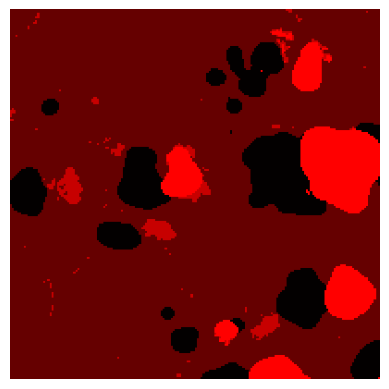

In [ ]:
def test(X):
  X = samples.dataset{'success': False, 'error': 'Erro HTTP 502: '}.open_tif(X)
  samples.dataset.show(X, -21.69401, -44.88277, 400, 400, 1, 2, 3)
  #samples.dataset.show(X, -21.69401, -44.88277, 1200, 1200, 22, 25, 25)
  samples.dataset.show(X, -21.69401, -44.88277, 400, 400, 18, 25, 25)
  samples.dataset.show(X, -21.69401, -44.88277, 400, 400, 14, 25, 25)

test("2025-02-09")

In [32]:
X = samples.dataset.open_tif("2025-02-14_scl")

In [31]:
def showSCL(X, i=0):
    scl_classes = {
        0: ("0 - Sem dados", (0, 0, 0)),
        1: ("1 - Saturado/Defeituoso", (255, 0, 0)),
        2: ("2 - Água", (0, 255, 255)),
        3: ("3 - Sombra de Nuvem", (0, 127, 255)),
        4: ("4 - Vegetação", (0, 255, 0)),
        5: ("5 - Solo", (255, 127, 127)),
        6: ("6 - Vegetação Rala", (127, 255, 82)),
        7: ("7 - Neve", (255, 255, 255)),
        8: ("8 - Nuvem Alta/Certa", (0, 0, 255)),
        9: ("9 - Núvem", (0, 0, 127)),
        10: ("10 - Construção/Urbano", (255, 165, 0)),
        11: ("11 - Nuvem Média/Provável", (127, 127, 255)),
    }

    colors = [np.array(color) / 255 for _, color in scl_classes.values()]
    cmap = mcolors.ListedColormap(colors)
    bounds = list(scl_classes.keys())
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    scl_layer = X[i]

    fig, ax = plt.subplots(figsize=(10, 8))

    img = ax.imshow(scl_layer, cmap=cmap, norm=norm)
    ax.axis("off")
    ax.set_title("Scene Classification Layer (SCL)")

    legend_patches = [mpatches.Patch(color=np.array(color) / 255, label=label) for label, color in scl_classes.values()]
    legend_ax = fig.add_axes([0.92, 0.2, 0.05, 0.6])  # Posição: [left, bottom, width, height]
    legend_ax.axis("off")
    legend_ax.legend(handles=legend_patches, loc="center left", fontsize="small", title="Classes SCL")

    plt.show()

showSCL(X)

In [33]:
showSCL(X)

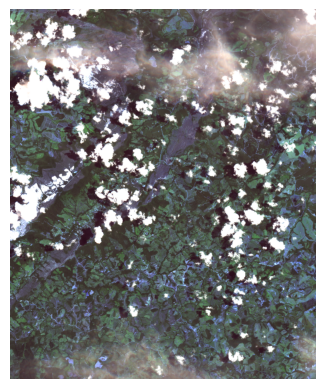

In [ ]:
tmp = samples.dataset.show(X, -21.69401, -44.88277, 2400, 2400, 1, 2, 3)

In [ ]:
samples.aquisitor.download('2025-02-09')

Exportando mosaico de: COPERNICUS/S2_SR_HARMONIZED/20250209T131311_20250209T131734_T23KMR, COPERNICUS/S2_SR_HARMONIZED/20250209T131311_20250209T131734_T23KMS, COPERNICUS/S2_SR_HARMONIZED/20250209T131311_20250209T131734_T23KNR, COPERNICUS/S2_SR_HARMONIZED/20250209T131311_20250209T131734_T23KNS
Exportação de 2025_02_09 iniciada.


'2025_02_09'

In [ ]:
for f in samples.dataset.list('tif'):
  print(f)
  X = carcara.dataset.open_tif(f[0:10])
  carcara.dataset.analysis(X, header_info=False)
  carcara.dataset.show(X, -21.69401, -44.88277, 1200, 1200, 1, 2, 3)